# Chapter 5: The Inner Sea in the Tragedies of Harpur and Baillie

Charles Harpur and Joanna Baillie were two of the preeminent tragideans of the Romantic period. Baillie achieved enormous fame in her lifetime, and considerable success on the stage. Harpur achieved considerable fame in New South Wales, where he was born and worked, and has posthumously been acclaimed by nationalist critics as the founder of Australia's dramatic tradition. In their theory and practice, these two dramatists pursued different tracks. While both were interested in forms of subjective drama, which portrayed the destruction or breakdown of the human psyche, Baillie's drama was a drama of interiority and psychology, while Harpur's drama was a drama of outward action and sociality. This notebook helps to draw this contrast between Baillie and Harpur, by using network analysis and text analysis to reveal the different structures of their plays.

The analysis in the notebook corresponds to Section 5.2 of *Romanticism and the Contingent Self.*

In [1]:
from math import inf, ceil, log
from typing import Tuple
import itertools

from romanticself import import_network_data, view_characters, view_communities, GraphCorpus
import igraph as ig
import pydracor as dc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.figure import Figure
from matplotlib.axes import Axes

corpus = import_network_data("data/drama-networks/", use_cache=False)

/opt/homebrew/Caskroom/miniforge/base/envs/py11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


The helper functions `view_characters` and `view_communities` allow you to peek at individual plays in the corpus.

In [2]:
view_characters(corpus, "dream", "top_20_distinctive_words")

Showing top 20 distinctive words for top 5 characters in The Dream by word count

Osterloo                 : loved, albert, midnight, awake, thank, before, art, thou, i, [...]
Jerome                   : son, paul, satisfied, frame, imagination, said, retire, form, [...]
Prior                    : die, draw, compelled, whole, order, sooner, halt, later, [...]
Benedict                 : fears, brother, moved, jerome, guilty, hadst, agitated, [...]
Leonora                  : agnes, benedict, oh, end, thy, marriage, rise, didst, door, [...]


In [3]:
view_communities(corpus, "harpur")

,names,keywords
0,"Bomebard, Tunbelly, Dreadnought, Cant, Tailor,...","bomebard, ned, worship, you, cant, worships, n..."
1,"Stalwart, Abel, Macblood, Landlady, Waltham","who, the, thy, me, and, you, it, i, to, but, o..."
2,"Rackroad, Filch, Desperate, Bushrangers, Mary,...","forest, ranger, welcome, free, we, the, life, ..."
3,"Ada, Lucy Grey, Mrs. Leslie","lucy, abel, you, the, and, i, herself, saw, bu..."
4,Old Shepherd,"guns, a, i, the, and, walking-stick, invented,..."


## Comparing the overall structures of the plays

**Figure 5.2** visualises the *Contingent Self* corpus to give a general view of the plays.

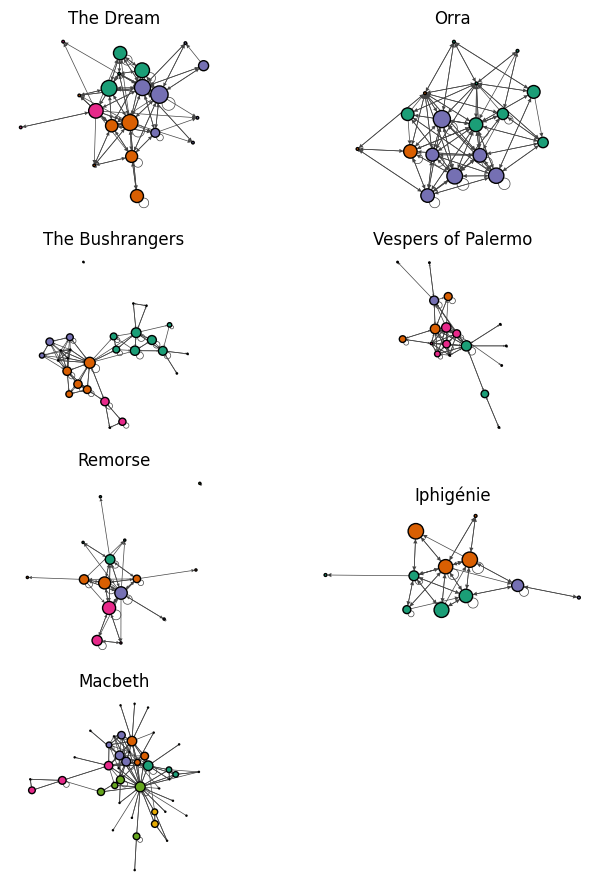

In [4]:
def get_comm_col(graph, colormap):
    return [colormap(num) for num in graph.vs["community"]]

def get_scaled_betweeness(graph, constant=1.0, scalar=5.0):
    return [log(val + constant, 10) * scalar for val in graph.betweenness(weights="weight")]

def plot_project_corpus(corpus: GraphCorpus, colormap) -> Tuple[Figure, list[list[Axes]]]:
    ncols = 2
    nrows = ceil(len(corpus) / ncols)
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols)
    fig.set_size_inches(8, 11)
    all_axes = itertools.chain.from_iterable(ax)
    for graph, axes in zip(corpus.values(), all_axes):
        axes.set_title(graph["title"])
        ig.plot(graph,
                vertex_size=get_scaled_betweeness(graph, constant=2, scalar=0.2),
                vertex_color=get_comm_col(graph, colormap),
                edge_width=0.5,
                autocurve=False,
                target=axes)
    # suppress unused axes
    ax[-1, -1].axis("off")
    return fig, ax

figure, axes = plot_project_corpus(corpus, mpl.cm.Dark2)
figure.savefig("figures/figure_5_2.png", bbox_inches="tight")

**Figure 5.3** compares the overall network topology of the seven plays in our small corpus with the network topology of a large number of plays in [DraCor](https://dracor.org).

In [5]:
dracor_df = pd.DataFrame.from_records([
    {
        "Corpus": corpus.title,
        "Year": play.get("year_normalized"),
        "Genre": play.get("normalized_genre"),
        "Size": play.get("num_of_speakers"),
        "Density": play.get("density"),
        "Clustering Coefficient": play.get("average_clustering"),
        "Average Path Length": play.get("average_path_length"),
        "ID": play.get("id")
    }
    for corpus in (dc.Corpus(lang) for lang in ["ger","fre","rus"])
    for play in corpus.metadata()
    if play.get("normalized_genre") == "Tragedy"
])

display(dracor_df)

,Corpus,Year,Genre,Size,Density,Clustering Coefficient,Average Path Length,ID
0,German Drama Corpus,1779,Tragedy,20,0.178947,0.642686,1.915584,ger000588
1,German Drama Corpus,1790,Tragedy,21,0.480952,0.825706,1.538095,ger000282
2,German Drama Corpus,1823,Tragedy,10,0.444444,0.615714,1.622222,ger000455
3,German Drama Corpus,1828,Tragedy,57,0.122807,0.818361,2.646707,ger000090
4,German Drama Corpus,1889,Tragedy,23,0.830040,0.910614,1.169960,ger000322
...,...,...,...,...,...,...,...,...
478,Russian Drama Corpus,1751,Tragedy,10,0.400000,0.685476,1.688889,rus000010
479,Russian Drama Corpus,1750,Tragedy,6,0.666667,0.805556,1.333333,rus000116
480,Russian Drama Corpus,1866,Tragedy,70,0.137474,0.819953,2.175966,rus000076
481,Russian Drama Corpus,1870,Tragedy,102,0.205591,0.959723,1.971399,rus000082


In [6]:
def period(year: int, breaks: list[int]) -> str:
    _breaks = [-inf, *breaks, inf]
    idxs = [idx for idx,val in enumerate(_breaks) if year < val]
    end = _breaks[min(idxs)]
    end = end - 1 if end != inf else ""
    start = _breaks[min(idxs) - 1]
    start = start if start != -inf else ""
    return f"{start}-{end}"

dracor_grouped = (dracor_df.assign(
    Year = [period(year, [1740, 1770, 1800, 1830]) for year in dracor_df["Year"]],
    ID = None)
    .groupby(["Corpus","Year"]))

In [7]:
dracor_analysis = dracor_grouped.mean(numeric_only=True).assign(Play = dracor_grouped.size()).reset_index()

In [8]:
contingent_self_analysis = pd.DataFrame(data= {
   "Corpus": "Contingent Self Corpus",
   "Year": [graph['date'] for graph in corpus.values()],
   "Play": [graph['title']for graph in corpus.values()],
   "Size": [len(graph.vs) for graph in corpus.values()],
   "Density": [graph.density() for graph in corpus.values()],
   "Clustering Coefficient": [graph.transitivity_avglocal_undirected(mode="zero") for graph in corpus.values()],
   "Average Path Length": [graph.average_path_length() for graph in corpus.values()],
   "Classes": [max(graph.vs["community"]) + 1 for graph in corpus.values()],
   "Modularity": [graph["modularity"] for graph in corpus.values()]
})

In [9]:
figure_5_3 = pd.concat([contingent_self_analysis, dracor_analysis])
figure_5_3.to_csv("figures/figure_5_3.csv")
display(figure_5_3)

,Corpus,Year,Play,Size,Density,Clustering Coefficient,Average Path Length,Classes,Modularity
0,Contingent Self Corpus,1812,The Dream,20.000000,0.313158,0.686881,1.821637,4.0,0.342066
1,Contingent Self Corpus,1812,Orra,17.000000,0.522059,0.664772,1.562500,3.0,0.268052
2,Contingent Self Corpus,1853,The Bushrangers,27.000000,0.188034,0.715722,2.672308,5.0,0.655762
3,Contingent Self Corpus,1823,Vespers of Palermo,18.000000,0.307190,0.477329,2.044118,4.0,0.421231
4,Contingent Self Corpus,1813,Remorse,15.000000,0.257143,0.461270,1.884615,5.0,0.435185
5,Contingent Self Corpus,1674,Iphigénie,11.000000,0.427273,0.602814,1.760000,3.0,0.298325
6,Contingent Self Corpus,1606,Macbeth,42.000000,0.109756,0.485837,2.474703,6.0,0.448476
0,French Drama Corpus,-1739,231,11.255411,0.494987,0.693271,1.584154,NaN,NaN
1,French Drama Corpus,1740-1769,36,9.222222,0.573652,0.709811,1.507406,NaN,NaN
2,French Drama Corpus,1770-1799,28,10.821429,0.523037,0.695482,1.498540,NaN,NaN


**Figure 5.4** displays the characteristic language of the different communities in *The Bushrangers*, *Orra* and *The Dream*.

In [10]:
case_studies = ["harpur", "orra", "dream"]
figure_5_4 = pd.concat(
    objs=[view_communities(corpus, play) for play in case_studies],
    keys=[corpus[play]["title"] for play in case_studies]
).reset_index().rename(columns={"level_0":"play", "level_1":"community"})
figure_5_4.to_csv("figures/figure_5_4.csv")
display(figure_5_4)

,play,community,names,keywords
0,The Bushrangers,0,"Bomebard, Tunbelly, Dreadnought, Cant, Tailor,...","bomebard, ned, worship, you, cant, worships, n..."
1,The Bushrangers,1,"Stalwart, Abel, Macblood, Landlady, Waltham","who, the, thy, me, and, you, it, i, to, but, o..."
2,The Bushrangers,2,"Rackroad, Filch, Desperate, Bushrangers, Mary,...","forest, ranger, welcome, free, we, the, life, ..."
3,The Bushrangers,3,"Ada, Lucy Grey, Mrs. Leslie","lucy, abel, you, the, and, i, herself, saw, bu..."
4,The Bushrangers,4,Old Shepherd,"guns, a, i, the, and, walking-stick, invented,..."
5,Orra,0,"Rudigere, Hughobert, Cathrina, Glottenbal, Mau...","i, the, and, to, thou, of, a, in, my, it, is, ..."
6,Orra,1,"Orra, Theobald, Outlaws","the, and, i, of, to, a, it, my, in, thou, is, ..."
7,Orra,2,"Franko, Hartman, Eleanora, Urston, Alice, Sold...","the, and, thou, to, is, i, a, not, in, of, tha..."
8,The Dream,0,"Jerome, Peasants, Sexton, Paul","the, it, me, to, of, and, son, a, us, i, grave..."
9,The Dream,1,"Benedict, Leonora, Morand, Agnes, Servants, Monks","the, me, and, i, of, is, to, benedict, it, the..."
